In [65]:
import pandas as pd
import numpy as np

# Погружаем данные в DataFrame
feat = pd.read_csv(r'd:\myproj\ml\7\features.csv', index_col='match_id')
# Копируем ответы 
trgt = feat['radiant_win'].copy()
# Количество объектов в выборке
objects_n = feat.shape[0]
# Убрать подсказки
feat.drop(['duration', 'radiant_win', 'tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire'], axis=1, inplace=True)

In [66]:
# Сформировать словарь параметров, значения которых не равны NaN
feat_n = {colname:feat[colname].count() for colname in feat.columns if feat[colname].count() < objects_n}
# Получить отсортированнный по количечтву заполненых значений список
sorted(feat_n.items(), key=lambda x: x[1])

[('first_blood_player2', 53243),
 ('radiant_flying_courier_time', 69751),
 ('dire_flying_courier_time', 71132),
 ('first_blood_team', 77677),
 ('first_blood_time', 77677),
 ('first_blood_player1', 77677),
 ('dire_bottle_time', 81087),
 ('radiant_bottle_time', 81539),
 ('radiant_first_ward_time', 95394),
 ('dire_first_ward_time', 95404),
 ('radiant_courier_time', 96538),
 ('dire_courier_time', 96554)]

In [67]:
# Теперь можно убрать значения NaN
feat.fillna(value=0, inplace=True)

In [68]:
import datetime
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')

# Генератор разбиений выборки для cv (везде один и тот же)
cv = KFold(objects_n, n_folds=5, shuffle=True, random_state=241)

# Функция обучения списка clf на данных X и y, которая возвращает оцекнки cv и время обучения для каждого из значений списка param
def learn_clf(clf, X, y):
    scores = np.zeros(len(clf))
    periods = np.zeros(len(clf))
    
    for i in range(len(clf)):
    
        start_time = datetime.datetime.now()
        
        for train, test in cv:
            clf[i].fit(X[train], y[train])
            y_predicted_f = clf[i].predict_proba(X[test])[:, 1]
            scores[i] += roc_auc_score(y[test], y_predicted_f)
        scores[i] /= cv.n_folds
        diff = datetime.datetime.now() - start_time
        periods[i] = float(diff.microseconds)/1000 + float(diff.seconds)*1000
    return scores, periods

# Нарисовать значения scores и period
def draw_sp(X, scores, periods):
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1)
    ax2 = ax1.twinx()
    ax1.plot(X, periods, 'b-')
    ax2.plot(X, scores, 'r-')
    ax1.set_ylabel('Periods (ms)', color='red')
    ax2.set_ylabel('Scores (auc_roc)', color='blue')
    plt.show()
    return

## GRADIENT BOOSTING

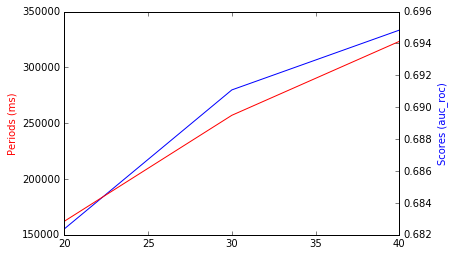

CV 30 trees duration is 279832.006 ms and auc-roc is 0.689


In [69]:
from sklearn.ensemble import GradientBoostingClassifier

# Список Параметров классификаторов
n_ests = [20, 30, 40];
# Список экземпляров классификаторов
clf_gb = [GradientBoostingClassifier(n_estimators=item, verbose=False, random_state=241, learning_rate=0.1, warm_start=False) for item in n_ests]
# Обучаем список
scores_gb, periods_gb = learn_clf(clf_gb, feat.values, trgt.values)
# Результаты обучения
draw_sp(n_ests, scores_gb, periods_gb)
# Время и качество обучения на 30 деревьях
print('CV 30 trees duration is', periods_gb[n_ests.index(30)], 'ms and auc-roc is', round(scores_gb[n_ests.index(30)], 3))

## LOGISTIC REGRESSION

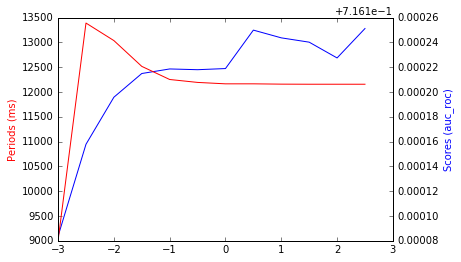

Наилучшее значение auc_roc при времени cv и значении настроечного параметра:
Град. бустинг: 0.694131110881 333377.068 40
Лог. регрессия: 0.716355604072 10945.626 0.00316227766017


In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Масштабирование данных относительно mean=0, std=1
scl = StandardScaler().fit(feat)
X_scaled = scl.transform(feat)

# Список Параметров классификаторов
C = np.power(10.0, np.arange(-3, 3, 0.5))

# Оказывается есть очень быстрая реализация, но поставим логистическую регрессию в те же условия что и градиентный бустинг!
#clf = LogisticRegressionCV(Cs=C, penalty='l2', cv=cv, scoring='roc_auc')
#clf.fit(scl.transform(feat), trgt)

# Список экземпляров классификаторов
clf_lr = [LogisticRegression(C=item, penalty='l2', random_state=241, warm_start=False) for item in C]
# Обучаем список
scores_lr, periods_lr = learn_clf(clf_lr, X_scaled, trgt.values)
# Результаты обучения
draw_sp(np.log10(C), scores_lr, periods_lr)
# Выводы по получившимся a(x)
print('Наилучшее значение auc_roc при времени cv и значении настроечного параметра:')
print('Град. бустинг:', max(scores_gb), periods_gb[np.argmax(scores_gb)], n_ests[np.argmax(scores_gb)])
print('Лог. регрессия:', max(scores_lr), periods_lr[np.argmax(scores_lr)], C[np.argmax(scores_lr)])

## PREPARE DUMMY HEROES

In [71]:
N  = np.max(feat[['r1_hero', 'r2_hero', \
      'r3_hero', 'r4_hero', 'r5_hero', \
      'd1_hero', 'd2_hero', 'd3_hero', \
      'd4_hero','d5_hero']].values)

print('Героев:', N)

# N — количество различных героев в выборке
X_pick = np.zeros((objects_n, N))

# Получим мешок слов
for i, match_id in enumerate(feat.index):
    for p in range(5):
        X_pick[i, feat.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, feat.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1
        
# Удалим категориальные признаки
feat.drop(['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero'], axis=1, inplace=True)  

Героев: 112


## LOGISTIC REGRESSION (no heroes)

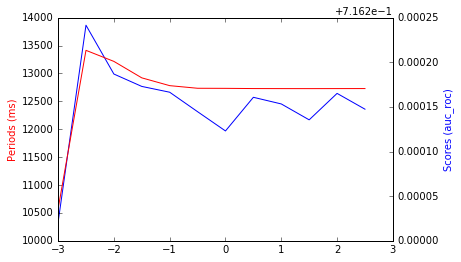

Наилучшее значение auc_roc при времени cv и значении настроечного параметра:
Лог. регрессия (без категориальных признаков): 0.716413328344 13863.793 0.00316227766017


In [8]:
# Масштабирование новых данных относительно mean=0, std=1
scl = StandardScaler().fit(feat)
X_scaled = scl.transform(feat)

# Список экземпляров классификаторов
clf_lrnh = [LogisticRegression(C=item, penalty='l2', random_state=241, warm_start=False) for item in C]
# Обучаем список
scores_lrnh, periods_lrnh = learn_clf(clf_lrnh, X_scaled, trgt.values)
# Результаты обучения
draw_sp(np.log10(C), scores_lrnh, periods_lrnh)

print('Наилучшее значение auc_roc при времени cv и значении настроечного параметра:')
print('Лог. регрессия (без категориальных признаков):', max(scores_lrnh), periods_lrnh[np.argmax(scores_lrnh)], C[np.argmax(scores_lrnh)])

## LEARN BY DUMMY HEROES

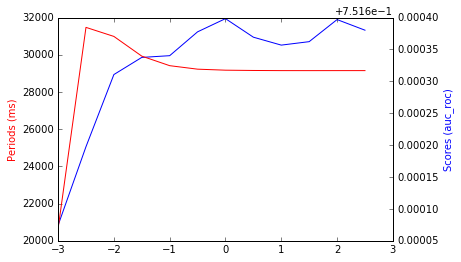

Наилучшее значение auc_roc при времени cv и значении настроечного параметра:
Лог. регрессия (мешок признаков): 0.751984664805 25058.433 0.00316227766017


In [54]:
X_dummy = np.hstack((feat.values, X_pick))

scl = StandardScaler().fit(X_dummy)
X_scaled = scl.transform(X_dummy)

# Список экземпляров классификаторов
clf_lrdh = [LogisticRegression(C=item, penalty='l2', random_state=241, warm_start=False) for item in C]
# Обучаем список
scores_lrdh, periods_lrdh = learn_clf(clf_lrdh, X_scaled, trgt.values)
# Результаты обучения
draw_sp(np.log10(C), scores_lrdh, periods_lrdh)

print('Наилучшее значение auc_roc при времени cv и значении настроечного параметра:')
print('Лог. регрессия (мешок признаков):', max(scores_lrdh), periods_lrdh[np.argmax(scores_lrdh)], C[np.argmax(scores_lrdh)])

## PREDICT

In [58]:
testd = pd.read_csv(r'd:\myproj\ml\7\features_test.csv')
testd.drop(['match_id'], axis=1, inplace=True)
testd.fillna(value=0, inplace=True)

# N — количество различных героев в выборке
X_pick = np.zeros((testd.shape[0], N))

In [60]:
for i, match_id in enumerate(testd.index):
    for p in range(5):
        X_pick[i, testd.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, testd.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1
        
testd.drop(['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero'], axis=1, inplace=True)

X_dummy = np.hstack((testd.values, X_pick))   

In [61]:
scl = StandardScaler().fit(X_dummy)
X_scaled = scl.transform(X_dummy)

# Берём обученный классификатор из массива с лучшим AUC_ROC!
y_predicted_f = clf_lrdh[np.argmax(scores_lrdh)].predict_proba(X_scaled)[:, 1]

[ 0.81601229  0.74600251  0.18690286 ...,  0.23453432  0.61981989
  0.43278838]


In [64]:
print('Максимальное значение:', round(max(y_predicted_f), 3))
print('Минимальное значение:', round(min(y_predicted_f), 3))

Максимальное значение: 0.996
Минимальное значение: 0.01
